In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

from sklearn.preprocessing import MinMaxScaler
import pyswarms as ps

from tensorflow import keras
from keras import layers, models
from keras import losses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 2.6 MB/s eta 0:00:00


In [2]:
df = pdr.get_data_yahoo('AMZN', start=None, end=None)

[*********************100%%**********************]  1 of 1 completed


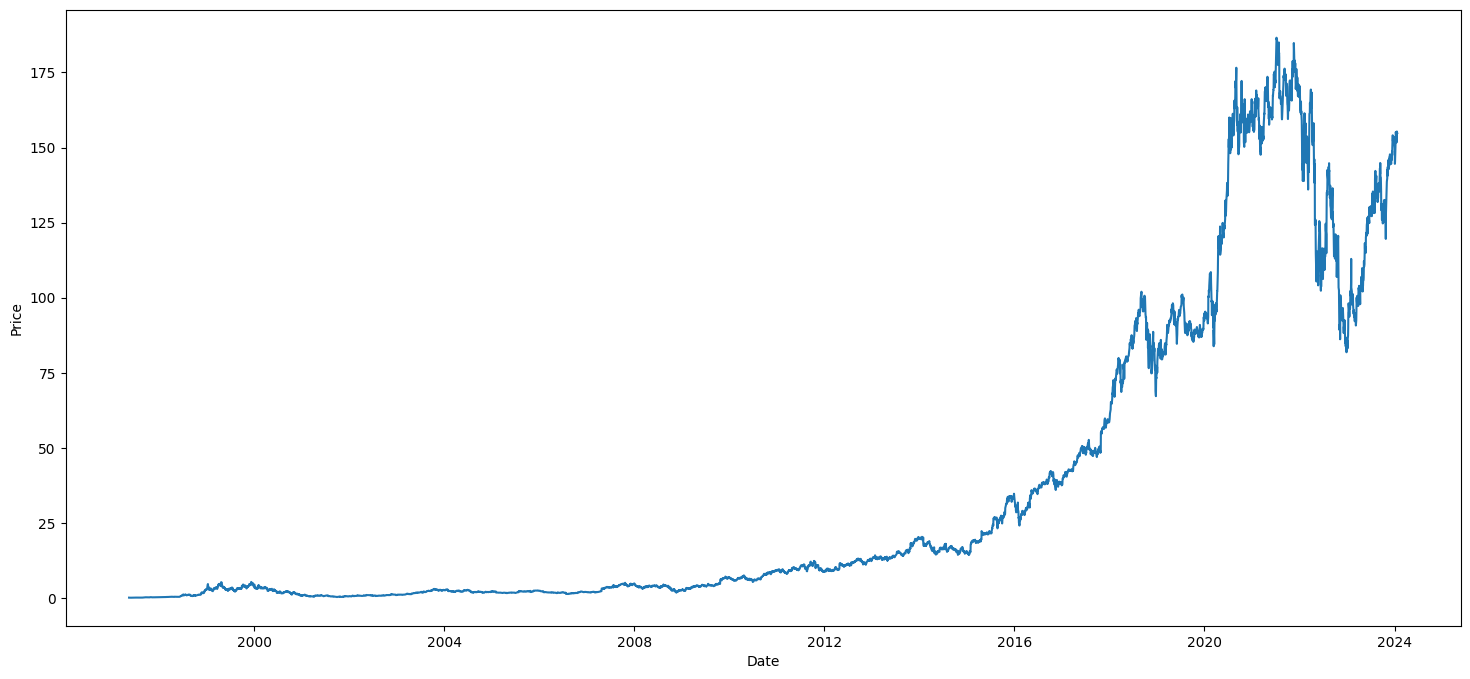

In [3]:
plt.figure(figsize=(18,8))
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [12]:
data = df.filter(['Close']) # should return a 2D array for the closing prices. Return type is a DataFrame

training_split_length = int(np.ceil(len(data)*0.65))

dataset = data.values # Return type of .values is a numpy.ndarray of dim 2

scalar = MinMaxScaler(feature_range=(0,1))
scaled_dataset = scalar.fit_transform(dataset)

scaled_dataset.shape

(6715, 1)

In [ ]:
train_data = scaled_dataset[:int(training_split_length),:]

x_train = []
y_train = []

days_in_advance = 4
# After some code analysis it turns out i'm actually ending up predicting 6 days in the future due to how indexing works.

for i in range(30,len(train_data)-days_in_advance):
    x_train.append(train_data[i-30:i,0])
    y_train.append(train_data[i+days_in_advance-1]) # To fix I'll need i-1+days_in_advance. Make sure of this though.

"""
  Because of this, i'm taking i as 30 first and adding 5 days so 35 days
  when x_train takes from [0-30[ or [0-29] so train data is 35 from 29 (6 days)
"""

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [13]:
def split_data(prev_days, scaled_dataset, training_split_length, dia):
    train_data = scaled_dataset[:int(training_split_length), :]
    x_train = []
    y_train = []
    for i in range(prev_days, len(train_data) - dia):
        x_train.append(train_data[i - prev_days:i, 0])
        y_train.append(train_data[i + dia - 1])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train

def create_model(layer_nodes, input_shape):
    model = keras.Sequential()
    for i, nodes in enumerate(layer_nodes):
        return_sequences = i < len(layer_nodes) - 1
        if i == 0:
            model.add(keras.layers.LSTM(nodes, return_sequences=return_sequences, input_shape=input_shape))
        else:
            model.add(keras.layers.LSTM(nodes, return_sequences=return_sequences))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

def evaluate_model(hyperparameters, scaled_dataset, training_split_length):
    layers = int(hyperparameters[0])  
    layer_nodes = [int(n) for n in hyperparameters[1:1 + layers]]  
    batch_size, epochs, prev_days = int(hyperparameters[1 + max_layers]), int(hyperparameters[2 + max_layers]), int(hyperparameters[3 + max_layers])
    
    x_train, y_train = split_data(prev_days, scaled_dataset, training_split_length, dia=4)
    model = create_model(layer_nodes, input_shape=(x_train.shape[1], 1))
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    val_loss = np.min(history.history['mean_squared_error'])
    return val_loss

def objective_function(hyperparameters, scaled_dataset, training_split_length):
    n_particles = hyperparameters.shape[0]
    j = [evaluate_model(hyperparameters[i], scaled_dataset, training_split_length) for i in range(n_particles)]
    return np.array(j)

options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_layers = 5  

lower_bounds = [1] + [10]*max_layers + [32, 10, 10]
upper_bounds = [max_layers] + [100]*max_layers + [64, 20, 100]
bounds = (lower_bounds, upper_bounds)

#Initialize swarm
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=len(bounds), options=options, bounds=bounds)

#Perform optimization
cost, pos = optimizer.optimize(objective_function, iters=5, scaled_dataset=scaled_dataset, training_split_length=training_split_length)

# Best hyperparameters
print("Best hyperparameters: Layers={}, Nodes={}, Batch Size={}, Epochs={}".format(int(pos[0]), int(pos[1]), int(pos[2]), int(pos[3])))

2024-01-23 08:19:53,999 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/5

Hyperparameters Shape: 10
[[ 2.74588934 60.07315266 54.28519816 17.5767259  38.8509796 ]
 [ 1.17480404 44.76598734 38.54531809 14.52481637 57.99776732]
 [ 1.96511603 24.79764081 50.93701872 12.90794717 58.0127194 ]
 [ 1.70042984 59.25516011 52.56869785 13.72167696 28.40321614]
 [ 2.28468011 21.71180596 46.51203021 11.23472863 74.06025482]
 [ 2.06233431 32.54051356 60.69196228 16.4989872  88.63462592]
 [ 2.94881029 54.5909084  34.52316057 15.57254368 62.58796384]
 [ 2.15715258 40.00423795 38.58012371 11.1425953  77.08768922]
 [ 2.21863551 21.75966094 32.27107369 13.36063904 41.13920471]
 [ 1.2811102  30.51642543 38.4350919  11.97490068 35.44586899]]


pyswarms.single.global_best:  20%|██        |1/5, best_cost=4.01e-6

Hyperparameters Shape: 10
[[ 2.8407805  56.33329569 53.33158421 16.00267497 38.72403816]
 [ 1.92539904 45.05252938 38.8037709  14.80978941 54.25212681]
 [ 2.08964589 26.17080604 50.94299492 12.86747864 52.28946697]
 [ 1.93473861 53.58304678 53.3574885  13.71509236 30.08877065]
 [ 2.25105312 24.39974943 44.88941096 12.15099971 69.75294163]
 [ 2.08946684 32.94538029 55.80275581 16.79847743 81.42226157]
 [ 1.70207211 53.72600096 35.67657634 15.87989023 62.47378845]
 [ 2.39260491 37.61819459 38.76077607 11.27288814 73.3687074 ]
 [ 2.5424907  22.4792763  34.69028523 13.82410138 40.84599816]
 [ 1.6889752  31.20910131 39.19004205 12.57538698 35.99217854]]


pyswarms.single.global_best:  40%|████      |2/5, best_cost=3.99e-6

Hyperparameters Shape: 10
[[ 2.90271653 51.98594901 49.93778877 14.32858951 40.76913123]
 [ 2.60093455 45.31041721 39.03637842 15.06626515 50.88105035]
 [ 2.13111485 28.29159936 49.4279552  12.97826106 47.88404611]
 [ 2.10730835 47.38335553 51.41222763 13.91548443 33.98225459]
 [ 2.1475268  31.2186321  43.43729891 13.37228734 64.63878215]
 [ 2.08339806 36.33145657 53.51794003 16.88766371 72.60970824]
 [ 2.38033039 52.25314499 36.82404973 15.96951886 60.83524602]
 [ 2.41579825 37.02411187 38.91007187 12.0723502  69.31694521]
 [ 2.73470425 25.1126273  37.02088775 14.47996396 44.37569135]
 [ 2.01493082 35.37763397 39.57039976 13.15124499 36.85883747]]


pyswarms.single.global_best:  60%|██████    |3/5, best_cost=3.99e-6

Hyperparameters Shape: 10
[[ 2.8262161  47.07058731 45.29235941 13.6639259  44.2552639 ]
 [ 2.92306052 45.40102122 39.17438708 15.18208114 49.6005991 ]
 [ 2.05747321 33.92686278 46.52134822 13.43611972 50.22806285]
 [ 2.14927883 42.20722018 47.52913959 14.12317154 42.32054532]
 [ 2.00008146 37.47844342 41.72364018 14.48483475 58.34448851]
 [ 2.02883357 41.12164476 52.49951696 16.37834041 68.05840238]
 [ 2.87362186 49.45772936 37.91104856 15.83476901 59.47251382]
 [ 2.28232705 38.07784891 38.94050895 12.38424063 67.53163998]
 [ 2.78341653 27.7951805  39.47434477 15.14290784 48.22116172]
 [ 2.20320689 38.70332808 39.17680018 13.72996465 41.0215365 ]]


pyswarms.single.global_best:  80%|████████  |4/5, best_cost=3.99e-6

Hyperparameters Shape: 10
[[ 2.64726745 42.89955053 44.07872362 14.24431302 48.25738793]
 [ 2.87658046 45.28278169 39.09430124 15.18174774 51.37580055]
 [ 1.94929195 38.95920494 45.0896874  13.78604754 56.4532778 ]
 [ 1.93150019 45.66427489 43.73931043 14.29244527 47.9087761 ]
 [ 1.86488756 43.30207085 39.71729148 15.48979952 51.8760566 ]
 [ 1.9740287  46.25866925 50.11274173 15.86341048 61.21031009]
 [ 2.88403827 47.62988818 37.8460787  15.57110049 59.04925814]
 [ 2.11657963 40.7753572  38.95159689 13.06622098 66.1871754 ]
 [ 2.67279248 34.53502907 41.55239768 15.71400074 53.48202992]
 [ 2.05445322 41.31882898 38.65904477 13.80519151 47.64034718]]


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=3.88e-6
2024-01-23 08:33:48,923 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.882138571498217e-06, best pos: [ 1.9740287  46.25866925 50.11274173 15.86341048 61.21031009]


Best hyperparameters: Layers=1, Nodes=46, Batch Size=50, Epochs=15


In [27]:
x_train, y_train = split_data(int(pos[4]), scaled_dataset, training_split_length, dia=4)
model = create_model(int(pos[0]), int(pos[1]), (x_train.shape[1], 1))
# model = create_model(1, 32, (x_train.shape[1], 1))

history = model.fit(x=x_train,y=y_train, batch_size=int(pos[2]), epochs=int(pos[3]))

Epoch 1/15
86/86 [==============================] - 6s 9ms/step - loss: 9.7094e-05 - mean_squared_error: 9.7094e-05 - mean_absolute_error: 0.0057
Epoch 2/15
86/86 [==============================] - 1s 9ms/step - loss: 5.7296e-06 - mean_squared_error: 5.7296e-06 - mean_absolute_error: 0.0016
Epoch 3/15
86/86 [==============================] - 1s 9ms/step - loss: 5.4486e-06 - mean_squared_error: 5.4486e-06 - mean_absolute_error: 0.0016
Epoch 4/15
86/86 [==============================] - 1s 9ms/step - loss: 5.8299e-06 - mean_squared_error: 5.8299e-06 - mean_absolute_error: 0.0017
Epoch 5/15
86/86 [==============================] - 1s 9ms/step - loss: 5.3575e-06 - mean_squared_error: 5.3575e-06 - mean_absolute_error: 0.0016
Epoch 6/15
86/86 [==============================] - 1s 9ms/step - loss: 5.7072e-06 - mean_squared_error: 5.7072e-06 - mean_absolute_error: 0.0017
Epoch 7/15
86/86 [==============================] - 1s 9ms/step - loss: 5.5219e-06 - mean_squared_error: 5.5219e-06 - mean_a

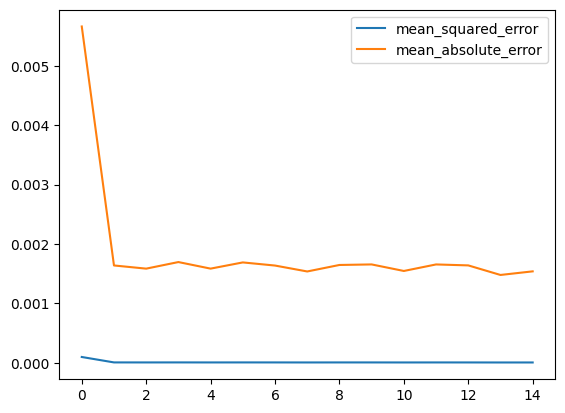

In [28]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.legend(['mean_squared_error', 'mean_absolute_error'])
plt.show()

In [29]:
test_data = scaled_dataset[training_split_length-int(pos[4]):,:]
x_test = []
y_test = dataset[training_split_length:, :]
for i in range(int(pos[4]), len(test_data)):
    x_test.append(test_data[i-int(pos[4]):i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scalar.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test)**2)))

rmse

74/74 [==============================] - 1s 4ms/step


12.160474635689166

In [30]:
diff = (np.max(dataset[training_split_length:])) - (np.min(dataset[training_split_length:]))
norm_rmse = 2.69336452210665/diff
norm_rmse



0.01563882053178519

<ipython-input-31-0234d146b869>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions[:,:]


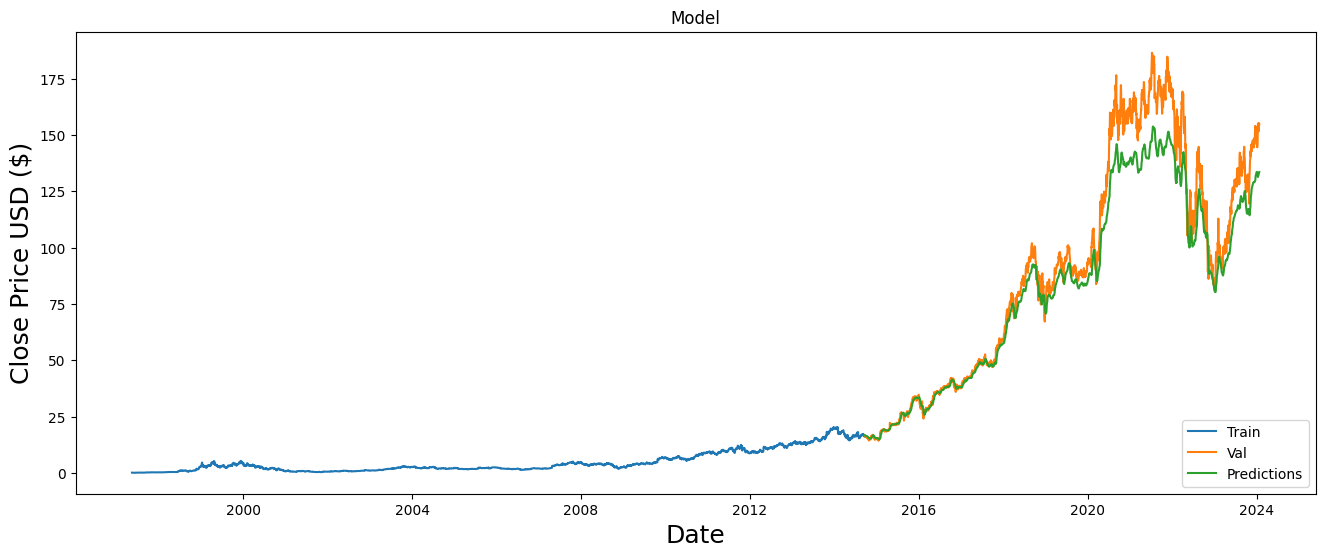

In [31]:
train = data[:training_split_length]
valid = data[training_split_length:]
valid['Predictions'] = predictions[:,:]
#Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [32]:
close_price = valid['Close'].values
prediction_price = valid['Predictions'].values
accuracy = lambda close, pred: min(close, pred)/max(close, pred) * 100
accuracy_lst = np.array([accuracy(close, pred) for close,pred in zip(close_price, prediction_price)])
accuracy = np.average(accuracy_lst)
accuracy

93.01236521507542

In [ ]:
late_test = scaled_dataset[-int(pos[4]):,:]
late_test = np.reshape(late_test, (1, int(pos[4]), 1))
late_test.shape

late_prediction = model.predict(late_test)
late_prediction = scalar.inverse_transform(late_prediction)
late_prediction

1/1 [==============================] - 0s 25ms/step


array([[140.41953]], dtype=float32)

In [ ]:
late_test = scaled_dataset[-33:-3,:]
late_test = np.reshape(late_test, (1, 30, 1))
late_test.shape

late_prediction = model.predict(late_test)
late_prediction = scalar.inverse_transform(late_prediction)
late_prediction

1/1 [==============================] - 0s 22ms/step


array([[149.40627]], dtype=float32)

In [ ]:
data.iloc[-33:-3,:]

,Close
Date,
2023-12-29,151.940002
2024-01-02,149.929993
2024-01-03,148.470001
2024-01-04,144.570007
2024-01-05,145.240005


In [ ]:
valid

,Close,Predictions
Date,,
2023-10-05,125.959999,128.367264
2023-10-06,127.959999,128.563629
2023-10-09,128.259995,128.504883
2023-10-10,129.479996,127.838013
2023-10-11,131.830002,128.783081
...,...,...
2024-01-04,144.570007,152.308731
2024-01-05,145.240005,151.080307
2024-01-08,149.100006,149.406265
